In [3]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# # Avoid OOM errors by setting GPU memory consumption growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True) # to tell tensorflow to allocate memory as needed

In [5]:
import cv2

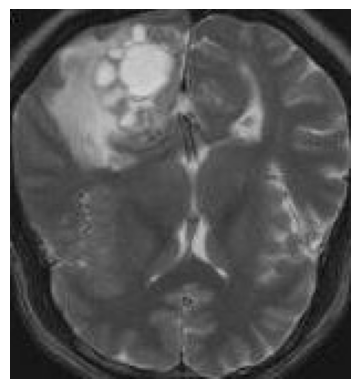

In [6]:
data_dir = 'preprocessed'
# open a random brain image, check if image has been processed
# grayscale -> gaussianBlur -> binary threshold -> erosion -> dilate -> contour
# Crop
img_raw = os.path.join(data_dir, 'malignant', 'y718.jpg')
img = cv2.imread(img_raw)

import matplotlib.pyplot as plt
# Convert image to normal
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [7]:
# for image_class in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, image_class)
#     for image in os.listdir(class_dir):
#         image_path = os.path.join(class_dir, image)
#         try:
#             tip = imghdr.what(image_path)
#             if tip not in image_extensions:
#                 os.remove(image_path)
#                 print("Removed (invalid format):", image_path)
#             else:
#                 img = cv2.imread(image_path)
#                 if img is None:
#                     os.remove(image_path)
#                     print("Removed (unable to read):", image_path)
#         except Exception as e:
#             print("Error processing:", image_path, "-", str(e))

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Building the data pipeline
# Reshapes the images to the same size, and normalizes the pixel values to a range of 0 to 1.
data = tf.keras.utils.image_dataset_from_directory('preprocessed')
valid = tf.keras.utils.image_dataset_from_directory('valid')

Found 2904 files belonging to 2 classes.
Found 24 files belonging to 2 classes.


In [10]:
# Accessing the data pipeline
data_iterator = data.as_numpy_iterator()

In [11]:
# Accessing the data itself in the pipeline
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [13]:
# Class 0 means benign images and Class 1 means malignant
batch[1]

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

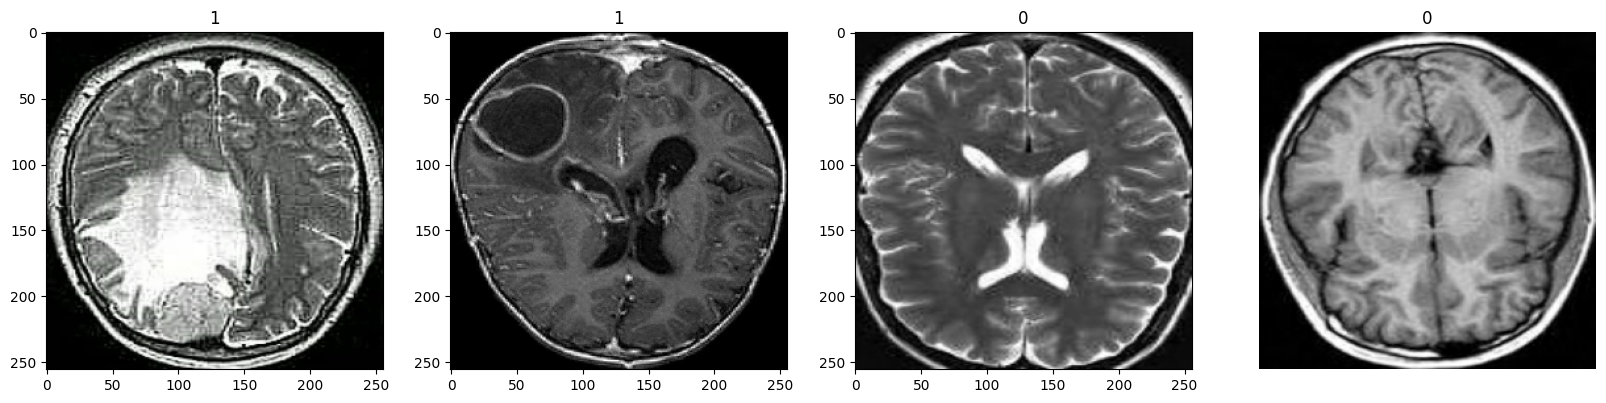

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
plt.axis('off')
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    plt.axis('off')

In [15]:
data = data.map(lambda x, y: (x/255, y))
valid = tf.keras.utils.image_dataset_from_directory('valid')
valid = valid.map(lambda x, y: (x/255, y))

Found 24 files belonging to 2 classes.


In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
batch[0].min()

0.0

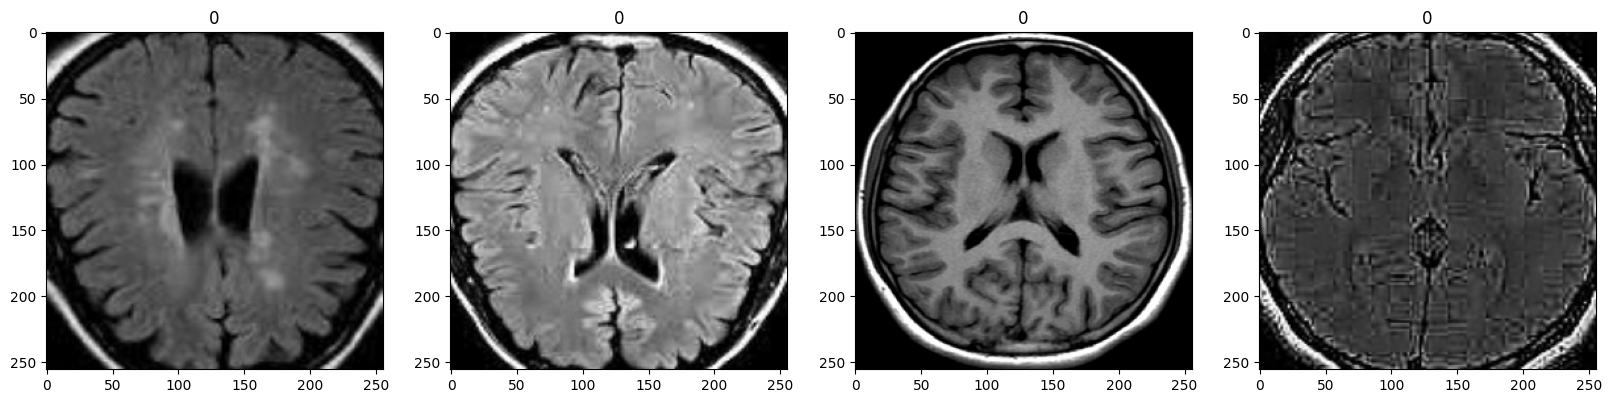

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [20]:
len(data)

91

In [21]:
train_size = int(len(data))
val_size = int(len(valid))

In [22]:
print(train_size)
print(val_size)

91
1


In [23]:
train = data.take(train_size)
validation = valid.take(val_size)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def make_model(input_shape):
    
    l2_lambda = 0.001  # Strength of L2 regularization

    inputs = keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)

    x = layers.Conv2D(32, 3, strides=2, padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x
    
    for size in [128, 256, 512, 728]:
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", depthwise_regularizer=regularizers.l2(l2_lambda), pointwise_regularizer=regularizers.l2(l2_lambda))(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", depthwise_regularizer=regularizers.l2(l2_lambda), pointwise_regularizer=regularizers.l2(l2_lambda))(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same", depthwise_regularizer=regularizers.l2(l2_lambda), pointwise_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(25, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)


In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',              # Monitor the training loss
    min_delta=0.001,             # Minimum change to qualify as an improvement
    patience=3,                 # Number of epochs to wait for improvement
    verbose=1,                   # Print messages
    mode='min',                  # 'min' because we want to minimize loss
    restore_best_weights=True    # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath='Zann_VGG.h5',  # Path where to save the model
                                                                        # The named formatting here will save the epoch number and the validation loss in the filename.
    save_weights_only=False,   # If True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
    save_best_only=False,      # If True, the latest best model according to the quantity monitored will not be overwritten.
    monitor='val_loss',        # Quantity to monitor.
    verbose=1,                 # Verbosity mode, 0 or 1.
    save_freq='epoch'          # Saves the model after each epoch.
)

In [29]:
learning_rate = 0.0001
image_size = (256, 256)

model = make_model(input_shape=image_size + (3,))

In [30]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                               

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
epochs = 82

hist = model.fit(train, epochs=epochs,  validation_data=validation, callbacks=[model_checkpoint_callback, early_stopping, tensorboard_callback])

Epoch 1/82
91/91 [==============================] - ETA: 0s - loss: 5.4064 - accuracy: 0.6391
Epoch 1: saving model to Zann_VGG.h5


/Users/zannlim/Desktop/Y4S1/IT1244/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 850s 9s/step - loss: 5.4064 - accuracy: 0.6391 - val_loss: 5.2612 - val_accuracy: 0.3333
Epoch 2/82
91/91 [==============================] - ETA: 0s - loss: 4.8372 - accuracy: 0.7820
Epoch 2: saving model to Zann_VGG.h5
91/91 [==============================] - 879s 10s/step - loss: 4.8372 - accuracy: 0.7820 - val_loss: 4.8789 - val_accuracy: 0.3750
Epoch 3/82
91/91 [==============================] - ETA: 0s - loss: 4.3979 - accuracy: 0.8302
Epoch 3: saving model to Zann_VGG.h5
91/91 [==============================] - 791s 9s/step - loss: 4.3979 - accuracy: 0.8302 - val_loss: 4.5244 - val_accuracy: 0.6667
Epoch 4/82
91/91 [==============================] - ETA: 0s - loss: 4.0477 - accuracy: 0.8492
Epoch 4: saving model to Zann_VGG.h5
91/91 [==============================] - 725s 8s/step - loss: 4.0477 - accuracy: 0.8492 - val_loss: 4.2278 - val_accuracy: 0.7917
Epoch 5/82
91/91 [==============================] - ETA: 0s - loss: 3.7040 - accuracy:

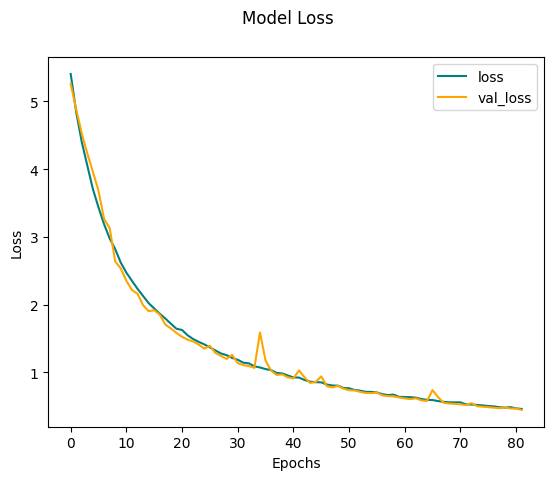

In [35]:
# Plot the model performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

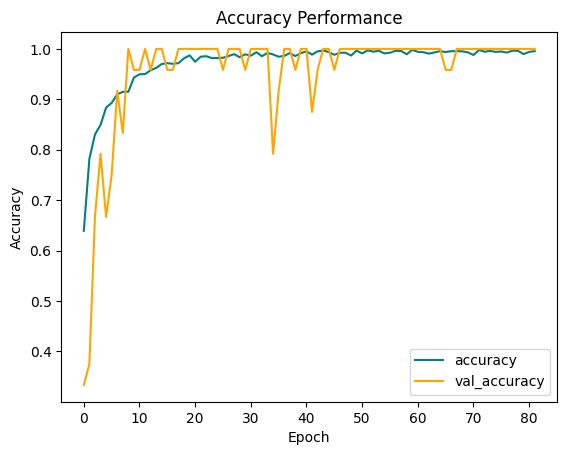

In [36]:
# Plot the accuracy performance
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [38]:
# Only if test set exists as tensors
# true_labels = []
# for image, label in test:
#     # `image` contains the image data
#     # `label` contains the label
#     print(f"Label: {label.numpy()}")
#     true_labels.append(label.numpy())

# true_labels = np.array(true_labels)
# print(true_labels)

In [39]:
test_dir = 'test'

In [41]:
test_images = []
true_labels = []
file_names = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    # Check if the item is a directory
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            img = cv2.imread(os.path.join(label_path, file))
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resize = tf.image.resize(img, [256, 256])
            test_images.append(resize)
            true_labels.append(label)
            file_names.append(file)

In [42]:
print(len(test_images), len(true_labels), len(file_names))
print(true_labels)

# Get index of first weapon image
index = true_labels.index('malignant')
print(index, file_names[index])

47 47 47
['malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign']
0 161.jpg


In [43]:
true = [1 if label == 'malignant' else 0 for label in true_labels]
true[15]

1

In [44]:
predictions = []
for predict in test_images:
    prediction = model.predict(np.expand_dims(predict/255, 0))
    predictions.append(prediction[0][0])

print(predictions)

1/1 [==============================] - 0s 86ms/step
[0.9999593, 0.99999833, 0.9999967, 0.9995485, 0.9999972, 0.9984676, 0.9997898, 0.99987614, 0.9981107, 0.9999947, 0.9335687, 0.9999999, 0.9999879, 0.9999997, 0.99994063, 1.0, 0.9999999, 0.1576729, 1.0, 0.95723677, 0.030878179, 0.9996235, 0.9998362, 1.0, 0.99983186, 0.9956034, 0.9998793, 0.9978855, 0.99987197, 0.999935, 0.99999964, 0.0008561906, 0.0031520068, 0.0018086961, 0.00035226662, 0.002288905, 0.000108304135, 0.0042416356, 0.9077378, 2.8113735e-05, 0.00015288345, 0.0030935323, 0.0032991797, 0.00070102804, 0.0075524077, 0.0005341529, 0.0043429616]


In [45]:
pred = [1 if prediction >= 0.5 else 0 for prediction in predictions]

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_score, recall_score, f1_score 
# Calculate accuracy
accuracy = accuracy_score(true, pred) #  accuracy
print("Accuracy:", accuracy*100, '%')

print("Micro F1_score:", f1_score(true, pred, average="micro"))
print("Weighted F1_score:", f1_score(true, pred, average="weighted"))

# Generate a classification report
class_report = classification_report(true, pred)
print("Classification Report:\n", class_report)

# Create a confusion matrix
confusion = confusion_matrix(true, pred)
print("Confusion Matrix:\n", confusion)

Accuracy: 93.61702127659575 %
Micro F1_score: 0.9361702127659575
Weighted F1_score: 0.9366141357770238
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.97      0.94      0.95        31

    accuracy                           0.94        47
   macro avg       0.92      0.94      0.93        47
weighted avg       0.94      0.94      0.94        47

Confusion Matrix:
 [[15  1]
 [ 2 29]]


<Axes: >

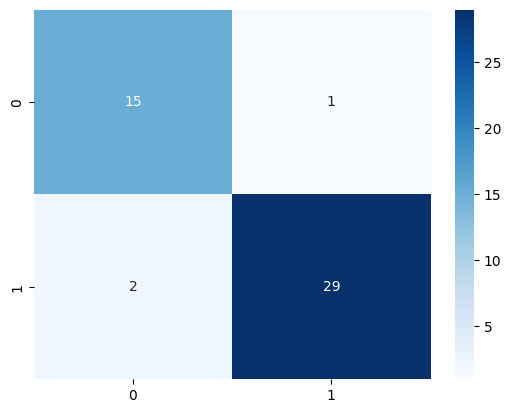

In [50]:
import seaborn as sns
sns.heatmap(confusion, annot=True, cmap='Blues')

In [51]:
model.save('VGG_model.h5')

/Users/zannlim/Desktop/Y4S1/IT1244/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
